## Import Libraries

In [1]:
#from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential ,load_model
from keras.layers import Dense, Dropout, Flatten
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import backend as K
from itertools import cycle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score

## Google Drive connection

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Preprocessing


In [3]:
dataset_path = "/content/drive/MyDrive/Haze-Fog-suppression/classifier/"

# path for dataset, models and test, validation and train folders
base_path_levels = '/content/drive/MyDrive/Haze-Fog-suppression/pix2pixHD/datasets/nebbia/train_A_old/'
base_path_nohaze = '/content/drive/MyDrive/Haze-Fog-suppression/pix2pixHD/datasets/nebbia/train_B_old/'
base_path = ''
test_path = dataset_path + 'dataset/Test/'
val_path = dataset_path + 'dataset/Validation/'
train_path = dataset_path + 'dataset/Train/'
models_path = dataset_path + 'dataset/models/'

# class list
classes = ['no_haze', 'low', 'medium', 'high']

# Utilities

In [ ]:
inceptionv3_results_path = os.path.join(models_path, 'InceptionV3')

def set_seed ():
	'''
	set_seed is used to obtain reproducible results using keras during the development phase
	'''
	seed = 10
	# The below is necessary for reproducible results of certain Python hash-based operations.
	os.environ["PYTHONHASHSEED"]="0"
	# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
	np.random.seed(seed)
	# The below is necessary for starting core Python generated random numbers in a well-defined state.
	rn.seed(seed)
	# The below tf.random.set_seed will make x number generation in TensorFlow have a well-defined initial state.
	tf.random.set_seed(seed)

# define image size and batch size
image_size = 512
batch_size = 16

# create data generator for train, test and validation
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# load images from train folder
train_generator = data_generator.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# load images from test folder
test_generator = data_generator.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# load images from validation folder
val_generator = data_generator.flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)


def show_training_and_validation_performance(history,path):
	'''
	show_training_and_validation_performance is used to plot the performances during the training phase
	:param history: object in which are recorded all the events
	'''
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	loss = history.history['loss']
	val_loss = history.history['val_loss']

	epochs = range(len(acc))

	plt.plot(epochs, acc, 'bo', label='Training accuracy')
	plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
	plt.title('Training and validation accuracy')
	plt.legend()

	plt.figure()

	plt.plot(epochs, loss, 'bo', label='Training loss')
	plt.plot(epochs, val_loss, 'b', label='Validation loss')
	plt.title('Training and validation loss')
	plt.legend()

	plt.savefig(path)

	plt.show()

def compile_model (model, optimizer='adam', learning_rate = 0.00001):
	'''
	compile_model is used to compile the current model
	:param model: model to compile
	:param optimizer: optimizer to be used
	:param learning_rate: learning rate parameter for the optimizer
	'''
	if optimizer == 'adam':
		model.compile(loss="categorical_crossentropy",
		optimizer=optimizers.Adam(learning_rate=learning_rate),
		metrics=["accuracy"])
	elif optimizer == 'rmsprop':
		model.compile(loss="categorical_crossentropy",
					optimizer = optimizers.RMSprop(learning_rate=learning_rate),
					metrics=['accuracy'])
	model.summary()

def run_model (model, type, model_name, epochs = 100, patience=5, monitor='val_loss'):
	'''
	run_model is used to run the current mode
	:param model: model to run
	:param model_name: name given to save the model
	:param type: type of model, CNN, VGG16, ResNet50, InceptionV3
	:param epochs: how many epochs to do
	:param patience: patience value for Early Stopping
	:param monitor: what to monitor for Early Stopping and Model Checkpoint
	'''
	# local save path for the models
	save_path = os.path.join(models_path, type + '/' + model_name + '.h5')
	callbacks_list = [
					keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
					keras.callbacks.ModelCheckpoint(
						filepath = save_path,
						monitor=monitor,
						verbose=1,
						save_best_only=False,
            save_weights_only=False)
					]
	history = model.fit(train_generator,
						epochs=epochs,
						validation_data=val_generator,
						callbacks=callbacks_list)
	# save on Drive only the best model
	show_training_and_validation_performance(history,os.path.join(models_path, type + '/' + model_name + '_validation.png'))

def plot_roc_curve(y_true, y_pred, n_classes, class_labels, model_name, type):

    # convert class labels to binary representation
    lb = LabelBinarizer()
    y_true_binary = lb.fit_transform(y_true)

    # calculate fpr and tpr for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true_binary[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['blue', 'red', 'green', 'purple']  # colors for each class

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve {0} ({1:0.2f}%)'.format(class_labels[i], roc_auc[i]*100))

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(models_path, type + '/' + model_name + '_ROC.png'))
    plt.show()

def evaluate_model (model, test_generator, model_name, type):
	'''
	evaluate_model is used to plot some statistics about the performance on the test set
	:param model: model to consider
	'''
	labels_d= ['no_haze', 'low', 'medium', 'high']

	# get predictions
	y_score = model.predict(test_generator)
	# convert predictions to classes
	y_pred = np.argmax(y_score, axis=-1)
	# get true classes
	y_true = test_generator.classes
	# extract class labels
	class_labels = list(test_generator.class_indices.keys())

	print("Classification report: ")
	# create and show classification report
	print(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))
	# save classification report
	with open(os.path.join(models_path, type + '/' + model_name + '_classification_report.txt'), 'w') as f:
		f.write(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))

	# create and show confusion matrix
	cm = confusion_matrix(y_true, y_pred)
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
	disp.plot(xticks_rotation=45)

	# save confusion matrix
	plt.savefig(os.path.join(models_path, type, model_name + '_confusion_matrix.png'), bbox_inches='tight', pad_inches=0.1)
	plt.show()

	plot_roc_curve(y_true, y_score, 4, class_labels, model_name, type)

def clear(model):
	del model
	K.clear_session()

set_seed ()

Found 10742 images belonging to 4 classes.
Found 3300 images belonging to 4 classes.
Found 2758 images belonging to 4 classes.


# Feature Extraction

## Load InceptionV3

In [ ]:
# load InceptionV3 model without the last layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 255, 255, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 255, 255, 32  96         ['conv2d[0][0]']                 
 alization)           

## Experiment 1
InceptionV3

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 flatten (Flatten)           (None, 401408)            0         
                                                                 
 dense (Dense)               (None, 128)               51380352  
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 73,183,652
Trainable params: 51,380,868
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/100
672/672 [==============================] - ETA: 0s - loss: 0.6240 - accuracy: 0.7354
Epoch 1: saving model to /content/drive/MyDrive/Haze-Fog-suppression/c

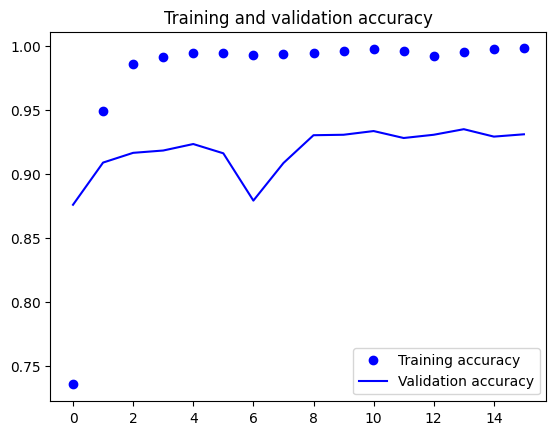

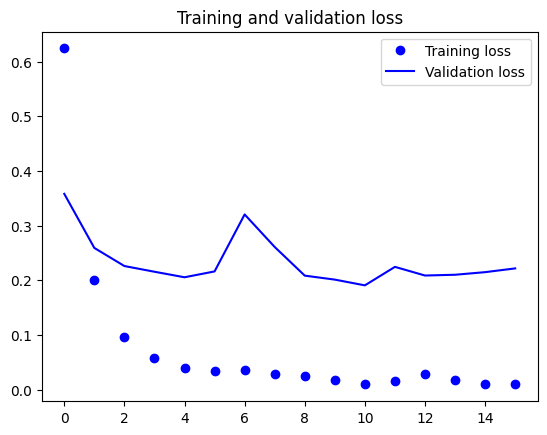

207/207 [==============================] - 1333s 6s/step
Classification report: 
              precision    recall  f1-score   support

        high     0.9561    0.9350    0.9454       815
         low     0.8938    0.9565    0.9241       827
      medium     0.9117    0.8863    0.8988       827
     no_haze     0.9767    0.9567    0.9666       831

    accuracy                         0.9336      3300
   macro avg     0.9346    0.9336    0.9337      3300
weighted avg     0.9345    0.9336    0.9337      3300



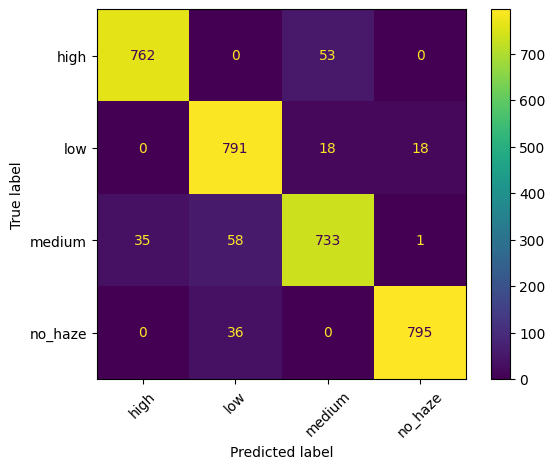

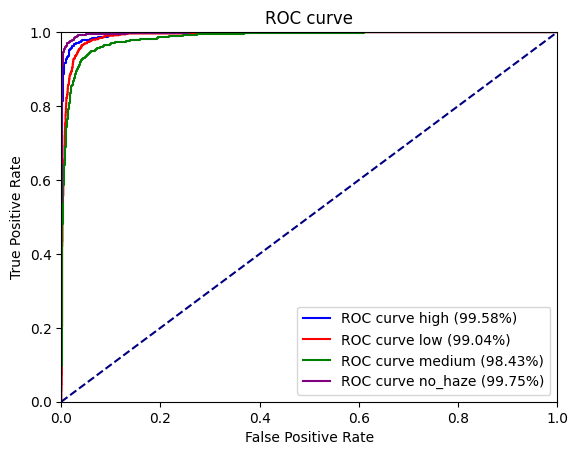

In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax')) 

# freeze the layers of the pretrained model
for layer in base_model.layers:
    layer.trainable = False

# compile the model
compile_model(model)

# run the model
run_model(model, 'InceptionV3', "InceptionV3_128")

# evaluate model
evaluate_model(model,test_generator, 'InceptionV3_128', "InceptionV3")

# SOTS evaluation

## preprocessing

In [ ]:
# test classifier on SOTS dataset

inceptionv3_results_path = os.path.join(models_path, 'InceptionV3')

In [4]:
classes = ['no_haze', 'low', 'medium', 'high']
# base directory for SOTS dataset
SOTS_base_directory = "/content/drive/MyDrive/Haze-Fog-suppression/classifier/dataset/SOTS"

# create a directory for each class if it doesn't exist
for class_name in classes:
    class_directory = os.path.join(SOTS_base_directory, class_name)

    # check if the directory exists
    if not os.path.exists(class_directory):
        os.makedirs(class_directory)
        print(f"Creata la cartella per {class_name}")
    else:
        print(f"La cartella per {class_name} esiste già")

Creata la cartella per no_haze
Creata la cartella per low
Creata la cartella per medium
Creata la cartella per high


In [5]:
# Copy indoor and outdoor images to NO_HAZE
def copy_images_from_gt_to_no_haze(source_folder, destination_folder):
    try:
        # Check if the "no_haze" destination folder exists, if not, create it
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)

        # Get the list of files from the "gt" folder
        gt_file_list = os.listdir(source_folder)

        # Copy each file from the "gt" folder to "no_haze"
        for file in gt_file_list:
            source_file = os.path.join(source_folder, file)
            destination_file = os.path.join(destination_folder, file)
            shutil.copy(source_file, destination_file)

        print("Image copy completed successfully.")
    except Exception as e:
        print(f"An error occurred while copying images: {str(e)}")

# Using the function to copy the images
indoor_source_folder = "/content/drive/MyDrive/Haze-Fog-suppression/dataset/SOTS/indoor/gt"
outdoor_source_folder = "/content/drive/MyDrive/Haze-Fog-suppression/dataset/SOTS/outdoor/gt"
destination_folder = "/content/drive/MyDrive/Haze-Fog-suppression/classifier/dataset/SOTS/no_haze"

copy_images_from_gt_to_no_haze(indoor_source_folder, destination_folder)
copy_images_from_gt_to_no_haze(outdoor_source_folder, destination_folder)


Copia delle immagini completata con successo.
Copia delle immagini completata con successo.


In [6]:
# Copy images for each class based on parsing the name

# Path to indoor hazy images folder
indoor_hazy_images_folder = "/content/drive/MyDrive/Haze-Fog-suppression/dataset/SOTS/indoor/hazy"

# Paths to destination folders
SOTS_low_folder = "/content/drive/MyDrive/Haze-Fog-suppression/classifier/dataset/SOTS/low"
SOTS_medium_folder = "/content/drive/MyDrive/Haze-Fog-suppression/classifier/dataset/SOTS/medium"
SOTS_high_folder = "/content/drive/MyDrive/Haze-Fog-suppression/classifier/dataset/SOTS/high"

# Extract the value "n" from the name of each image and move it based on the value
for image_name in os.listdir(indoor_hazy_images_folder):
    if image_name.endswith(".png"):
        try:
            n = int(image_name.split("_")[1].split(".")[0])
            if 1 <= n <= 3:
                destination = SOTS_low_folder
            elif 4 <= n < 7:
                destination = SOTS_medium_folder
            else:
                destination = SOTS_high_folder

            # Move the image to the appropriate destination folder
            source = os.path.join(indoor_hazy_images_folder, image_name)
            destination = os.path.join(destination, image_name)
            shutil.copy(source, destination)
            print(f"Image '{image_name}' copied to '{destination}'")
        except Exception as e:
            print(f"Error processing image '{image_name}': {str(e)}")

print("Operation completed.")


Immagine '1400_1.png' copiata in '/content/drive/MyDrive/Haze-Fog-suppression/classifier/dataset/SOTS/low/1400_1.png'
Immagine '1400_10.png' copiata in '/content/drive/MyDrive/Haze-Fog-suppression/classifier/dataset/SOTS/high/1400_10.png'
Immagine '1400_2.png' copiata in '/content/drive/MyDrive/Haze-Fog-suppression/classifier/dataset/SOTS/low/1400_2.png'
Immagine '1400_3.png' copiata in '/content/drive/MyDrive/Haze-Fog-suppression/classifier/dataset/SOTS/low/1400_3.png'
Immagine '1400_4.png' copiata in '//content/drive/MyDrive/Haze-Fog-suppression/classifier/dataset/SOTS/medium/1400_4.png'
Immagine '1400_5.png' copiata in '//content/drive/MyDrive/Haze-Fog-suppression/classifier/dataset/SOTS/medium/1400_5.png'
Immagine '1400_6.png' copiata in '//content/drive/MyDrive/Haze-Fog-suppression/classifier/dataset/SOTS/medium/1400_6.png'
Immagine '1400_7.png' copiata in '/content/drive/MyDrive/Haze-Fog-suppression/classifier/dataset/SOTS/high/1400_7.png'
Immagine '1400_8.png' copiata in '/conte

## Test classifier with RESIDE SOTS dataset

In [12]:
inceptionv3_results_path_SOTS = os.path.join(models_path, 'SOTS/InceptionV3')

def set_seed():
    '''
    set_seed is used to obtain reproducible results using Keras during the development phase
    '''
    seed = 10
    # The following is necessary for reproducible results of certain Python hash-based operations.
    os.environ["PYTHONHASHSEED"] = "0"
    # The following is necessary for starting Numpy generated random numbers in a well-defined initial state.
    np.random.seed(seed)
    # The following is necessary for starting core Python generated random numbers in a well-defined state.
    rn.seed(seed)
    # The following tf.random.set_seed will make x number generation in TensorFlow have a well-defined initial state.
    tf.random.set_seed(seed)

# Define image dimensions
image_size = 512
batch_size = 16

# Create an ImageDataGenerator object for image preprocessing
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Load images from the test set
SOTS_test_generator = data_generator.flow_from_directory(
    "/content/drive/MyDrive/Haze-Fog-suppression/classifier/dataset/SOTS",
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

def SOTS_plot_roc_curve(y_true, y_pred, n_classes, class_labels, model_name, type):
    # Convert class labels into binary format
    lb = LabelBinarizer()
    y_true_binary = lb.fit_transform(y_true)

    # Calculate FPR and TPR rates for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true_binary[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['blue', 'red', 'green', 'purple']  # Colors for different classes

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve {0} ({1:0.2f}%)'.format(class_labels[i], roc_auc[i]*100))

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(models_path, type + '/' + model_name + '_SOTS_ROC.png'))
    plt.show()

def SOTS_evaluate_model(model, SOTS_test_generator, model_name, type):
    '''
    evaluate_model is used to plot some statistics about the performance on the test set
    :param model: model to consider
    '''
    labels_d = ['no_haze', 'low', 'medium', 'high']

    # Get predictions
    y_score = model.predict(SOTS_test_generator)
    # Convert predictions to classes
    y_pred = np.argmax(y_score, axis=-1)
    # Get true classes
    y_true = SOTS_test_generator.classes
    # Extract class labels
    class_labels = list(SOTS_test_generator.class_indices.keys())

    print("Classification report: ")
    # Create and display the classification report
    print(metrics.classification_report(y_true, y_pred, target_names=class_labels, digits=4))
    # Save the classification report
    with open(os.path.join(models_path, type + '/' + model_name + '_classification_report_SOTS.txt'), 'w') as f:
        f.write(metrics.classification_report(y_true, y_pred, target_names=class_labels, digits=4))

    # Create and display the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(xticks_rotation=45)

    # Save the confusion matrix
    plt.savefig(os.path.join(models_path, type, model_name + '_confusion_matrix_SOTS.png'), bbox_inches='tight', pad_inches=0.1)
    plt.show()

    SOTS_plot_roc_curve(y_true, y_score, 4, class_labels, model_name, type)



Found 1042 images belonging to 4 classes.


66/66 [==============================] - 31s 295ms/step
Classification report: 
              precision    recall  f1-score   support

        high     0.6224    0.3050    0.4094       200
         low     0.3129    0.5800    0.4065       150
      medium     0.2880    0.2400    0.2618       150
     no_haze     0.9113    0.9096    0.9104       542

    accuracy                         0.6497      1042
   macro avg     0.5337    0.5086    0.4970      1042
weighted avg     0.6800    0.6497    0.6484      1042



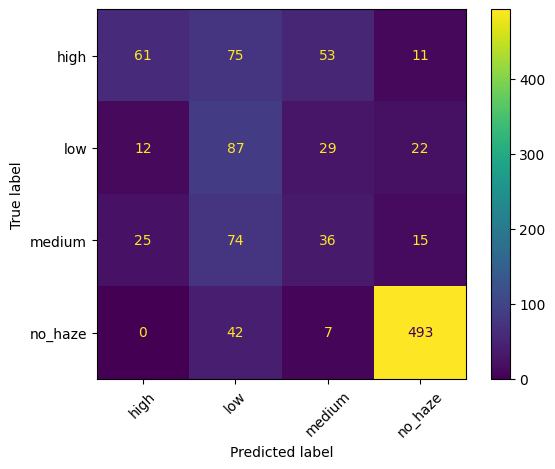

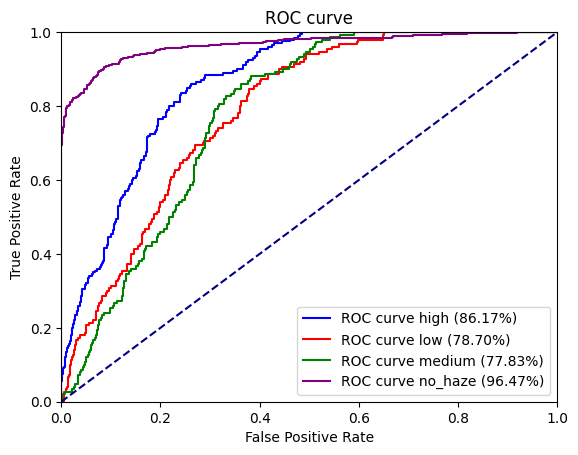

In [13]:
inceptionV3_model = load_model("/content/drive/MyDrive/Haze-Fog-suppression/classifier/dataset/models/InceptionV3/InceptionV3_128.h5")
SOTS_evaluate_model(inceptionV3_model, SOTS_test_generator, "InceptionV3_128", "InceptionV3")